In [2]:
#loading data
words = open('../names.txt','r').read().splitlines()

In [4]:
import torch
print(torch.__version__)

2.5.1+cpu


In [47]:
N = torch.zeros((28,28),dtype = torch.int32)

In [5]:
#stoi and itos dicts
chars = ['.']+sorted([chr(char) for char in range(ord('a'),ord('z')+1)])
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}

In [22]:
# normalising data in the form of 2d tensor
for word in words:
    chs = ['.']+list(word)+['.'] # taking . as special characters
    for cha,chb in zip(chs,chs[1:]):
        i,j = stoi[cha],stoi[chb]
        N[i,j]+=1


In [ ]:
#plotting
import matplotlib.pyplot as plt
%matplotlib inline

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

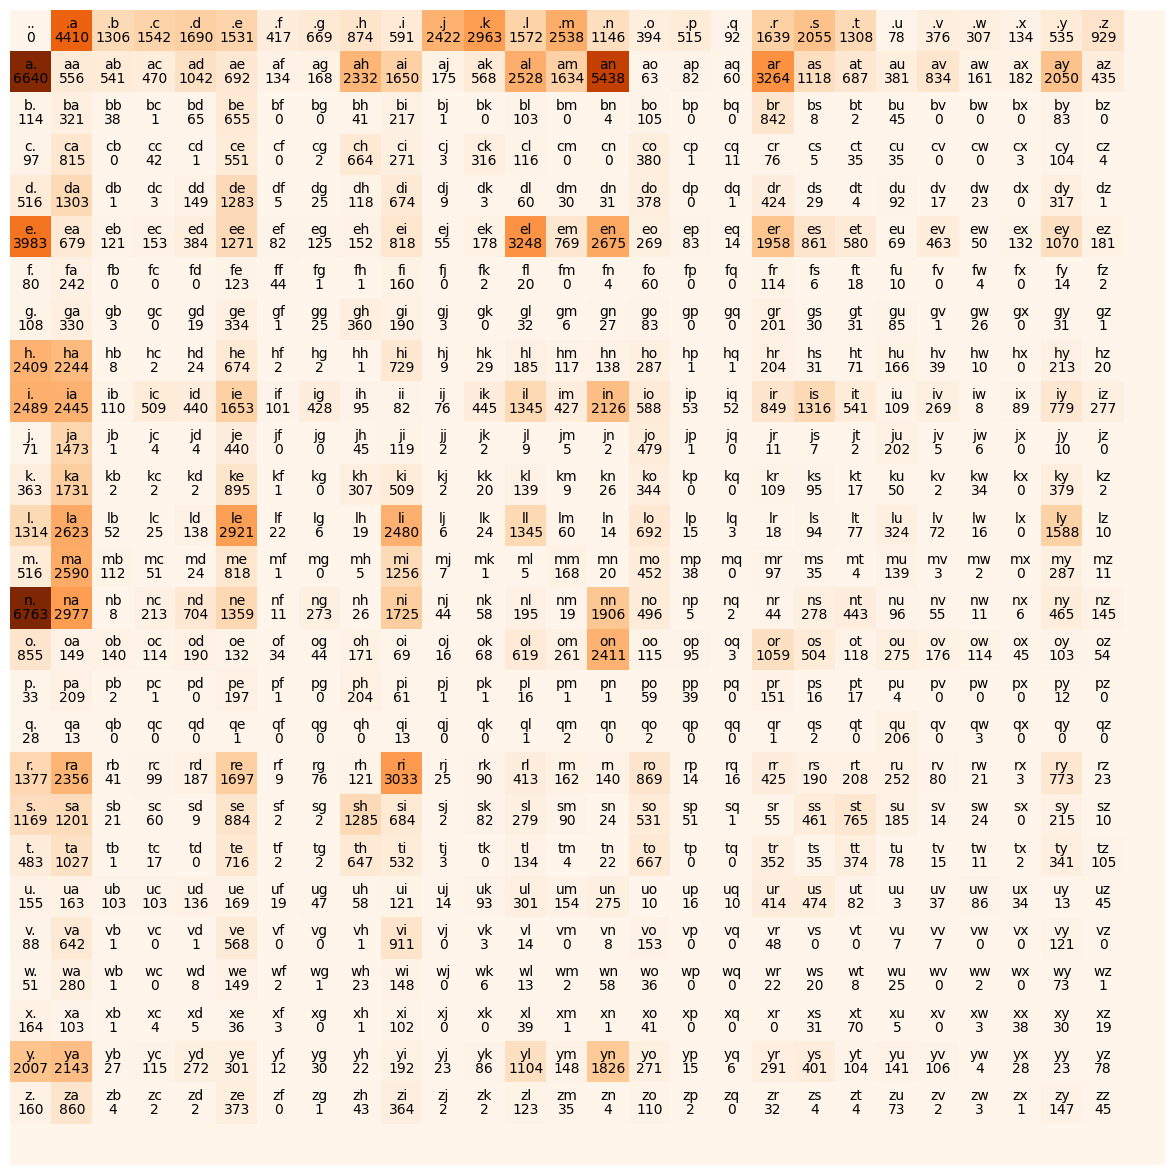

In [55]:
plt.figure(figsize=(15,15))
plt.imshow(N, cmap='Oranges')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='black')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='black')
plt.axis('off')

In [84]:
p = N[0].float()

In [85]:
p/=p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290,
        0.0000])

In [309]:
# P =       (27,27)
#P.sum(1) = (27,01)   
# broadcasting rule is that any binary operation like division between two tensors is possible (meaning the two tensors are broadcastable) only when all the dimensions when aligned for both right to left than starting from right the corresponding dimensions should either be same, one of them is none or 1.  
P = (N+1).float() #model smoothing.
P/=P.sum(1,keepdim=True)

In [310]:
g = torch.Generator().manual_seed(2147483647)
ix =0

for _ in range(10):
    nameList = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p,num_samples=1,replacement=True,generator=g).item()
        if ix==0:
            break
        nameList.append(itos[ix])
    print(''.join(nameList))


junide
janasah
p
cony
a
nn
kohin
tolian
juee
ksahnaauranilevias


In [311]:
neg_log_likelihood=0.0
ncount=0
for w in words:
    chs = ['.']+list(w)+['.']
    for cha,chb in zip(chs,chs[1:]):
        i,j = stoi[cha],stoi[chb]
        prob = P[i,j]
        neg_log_likelihood-=torch.log(prob)
        ncount+=1


In [312]:
print(f'{neg_log_likelihood=}')
print(f'normalised nll = {neg_log_likelihood/ncount}')


neg_log_likelihood=tensor(559978.7500)
normalised nll = 2.4544754028320312


In [8]:
#neural net approach to the bigram language model.
# training set:
xs,ys = [],[]

for word in words[:1]:
    w = ['.']+list(word)+['.']
    for cha,chb in zip(w,w[1:]):
        xs.append(stoi[cha])
        ys.append(stoi[chb])

xs,ys = torch.tensor(xs),torch.tensor(ys)

In [9]:
xs

tensor([ 0,  5, 13, 13,  1])

In [10]:
ys

tensor([ 5, 13, 13,  1,  0])

In [12]:
import torch.nn.functional as F

In [13]:
xenc = F.one_hot(xs,num_classes=27).float()
yenc = F.one_hot(ys,num_classes=27).float()

In [15]:
W = torch.randn((27,27),requires_grad=True)

In [39]:
step_size =0.01
for i in range(10):
    #forward pass
    # logits = xenc@W 
    logits = W[xs,:] # we can just take the xs row that would work too
    counts = logits.exp()
    probs = counts/counts.sum(1,keepdim=True) # normalised counts.
    loss = -probs[torch.arange(len(ys)),ys].log().mean() + 0*(W**2).mean() # loss + smoothing factor*(loss regularization)

    #backward pass
    W.grad = None
    loss.backward()

    #update
    W.data+=W.grad*step_size*-0.001

    print(loss)


tensor(2.6792, grad_fn=<AddBackward0>)
tensor(2.5899, grad_fn=<AddBackward0>)
tensor(2.5026, grad_fn=<AddBackward0>)
tensor(2.4173, grad_fn=<AddBackward0>)
tensor(2.3340, grad_fn=<AddBackward0>)
tensor(2.2528, grad_fn=<AddBackward0>)
tensor(2.1739, grad_fn=<AddBackward0>)
tensor(2.0972, grad_fn=<AddBackward0>)
tensor(2.0228, grad_fn=<AddBackward0>)
tensor(1.9507, grad_fn=<AddBackward0>)


In [24]:
logits = W[xs,:]
logits

tensor([[-1.8257, -0.5353,  0.2234, -0.7696, -0.8715, -0.6224,  2.4891, -1.6067,
          0.8273, -0.6681,  0.2967, -0.1258, -0.0976,  0.0764, -0.0591,  0.7451,
          0.0239,  0.0371,  0.2374, -1.5962, -0.6780,  0.1570,  2.5865,  0.1801,
          1.3502, -0.4351, -1.0814],
        [ 2.1829,  1.5206,  0.0224, -0.7194, -0.3149, -3.1978,  0.8592,  2.1545,
         -0.5742, -0.8034, -1.1839, -0.2527, -0.6693,  0.7004, -0.7481,  2.0508,
          1.7635,  0.2833,  0.2763,  1.0949, -0.4319,  0.0890, -0.9823,  0.0934,
         -0.2824, -1.5017,  2.6043],
        [-0.2374, -1.2166, -0.3720,  1.0746,  1.0251,  0.5636, -0.3108, -0.5614,
         -1.6551,  1.2859, -0.9975, -0.5924, -0.4663,  0.0234, -1.9233, -2.6339,
         -0.6590,  0.2218,  0.2572,  0.0186, -0.0780,  1.9120,  1.0675,  1.5214,
          0.9377, -2.0124, -0.4459],
        [-0.2374, -1.2166, -0.3720,  1.0746,  1.0251,  0.5636, -0.3108, -0.5614,
         -1.6551,  1.2859, -0.9975, -0.5924, -0.4663,  0.0234, -1.9233, -2.6339

In [25]:
xenc@W

tensor([[-1.8257, -0.5353,  0.2234, -0.7696, -0.8715, -0.6224,  2.4891, -1.6067,
          0.8273, -0.6681,  0.2967, -0.1258, -0.0976,  0.0764, -0.0591,  0.7451,
          0.0239,  0.0371,  0.2374, -1.5962, -0.6780,  0.1570,  2.5865,  0.1801,
          1.3502, -0.4351, -1.0814],
        [ 2.1829,  1.5206,  0.0224, -0.7194, -0.3149, -3.1978,  0.8592,  2.1545,
         -0.5742, -0.8034, -1.1839, -0.2527, -0.6693,  0.7004, -0.7481,  2.0508,
          1.7635,  0.2833,  0.2763,  1.0949, -0.4319,  0.0890, -0.9823,  0.0934,
         -0.2824, -1.5017,  2.6043],
        [-0.2374, -1.2166, -0.3720,  1.0746,  1.0251,  0.5636, -0.3108, -0.5614,
         -1.6551,  1.2859, -0.9975, -0.5924, -0.4663,  0.0234, -1.9233, -2.6339,
         -0.6590,  0.2218,  0.2572,  0.0186, -0.0780,  1.9120,  1.0675,  1.5214,
          0.9377, -2.0124, -0.4459],
        [-0.2374, -1.2166, -0.3720,  1.0746,  1.0251,  0.5636, -0.3108, -0.5614,
         -1.6551,  1.2859, -0.9975, -0.5924, -0.4663,  0.0234, -1.9233, -2.6339